# Lecture XII: A simple 1D SPH

Starting from the lesson on Hydrodynamical methods, let's implement a simple 1D SPH code aimed to perform at least 1 step of a shock-tube problem.

The fundamental SPH equation for the density is:

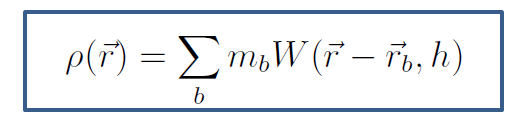

we are going to use a spline kernel, that is:

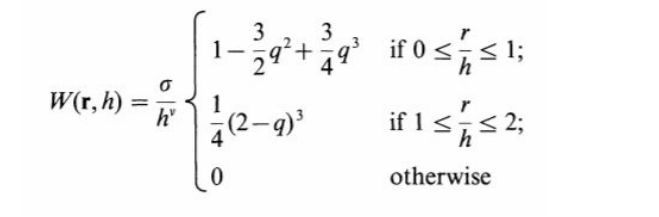


where $q=r_{ab}/h$, $R_{ab}$ is the distance between couple of particles $a$ and $b$, and, in 1D, 

$$
\sigma= \frac{2}{3}
$$


As a first step, we will study an **appropriate data structure** for SPH particles, an appropriate code-units system (in this case can be CGS or MKS), and implement functions to:
 - set up Shock-tube initial conditions:
 - find neighbours of each particle, within 2h:
 - compute densities for all particles.
 
 

## Shock-tube initial conditions


Initially we will have an high-pressure, high density left zone (LZ) and a low-pressure, low-density right zone (RZ).
The initial condition should be built as follows:

Pressure: LZ = 100000 [Pa]; RZ = 10000 [Pa]

Velocity: LZ = RZ = 0 [m/s]

Density: LZ = 1. [kg/m​3​]; RZ = 0.125 [kg/m​3​]

Tube area: 1m​2

Note: the advise is to build ICs so that every particle has the same mass. Thus the initial number of paticle per zone will scale with the density of the zone.

For instance, if we sample the whole tube with N particles (e.g N=3600) sinche LZ has a density that is eight time that of the RZ, we will have N_LZ=3200 and N_RZ=400.

Plot the result to verify it's correct.

## Neighbours.

We suggest to buils a very simple function to find neighbours at the beginning, e.g. using quicksort.

In our last lesson, we will instead use a binary tree. 

We will need a tree structure that goes from the root (at **1/2** of the IC segment) to a leaf having size **h**.
It will contain the information about how many particles are present in each branch, and function to determine how many particles are contained in $x-2h, x+2h$ given a position $x$ (that will be that of each SPH particle).

Begin to think about this but *test the SPH code using the simplest neighbour search*.



## Density computation

At this point, write a function to compute the density foe each SPH particle. You will need the formula shown above and the neighbour search. Try to write the function so that it can be parallelized with OpenMP.

For **h**, we suggest to use $h=32*L/N$ where $L$ is the box length and $N$ the particle number, so that, on average, h will contain 32 neighbours (and in 1D, 2h will have 64).

However you can play with h to see the effect of varying it. Note that in this very simple implementation, we keep $h$ constant.

Also in this case, plot the result. What changes with respect to the direct scatter plot of your ICs?

## Hydro force and energy computation

In this implementation, we will use the Standard-SPH formulation, without corrections for the variable $h$ (since we keep it fixed), and with the artificial viscosity. Thus, Euler and Energy equations are:

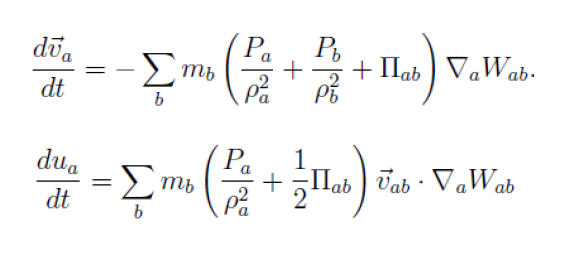

with the artificial viscosity given by:

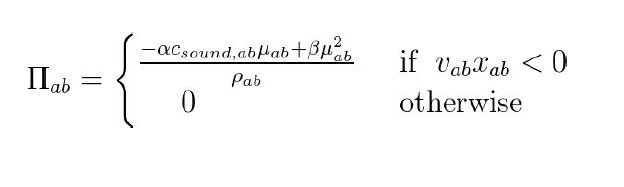

the term $\mu$ is:

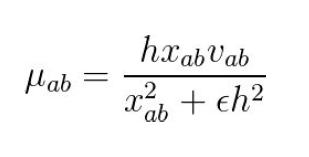

here:

- we choose $\alpha=1$, $\beta=2$;
- $x_{ab}=r_{ab}=r_a-r_b$; $v_{ab} = v_a-v_b$; pay attentions to the signs;
- $\rho_{ab}= (\rho_a+\rho_b)/2$ ;
- $\epsilon=0.01$ (this is used to protect $\mu$ from a singularity if the two particles are too close to each other);
- $c_{sound, ab} = (c_{sound,a}+c_{sound,b})/2$ is the average sound velocity, where $c_{sound}= \sqrt{\gamma P/\rho}$.

The system is closed by the equation of state:

$$
P=(\gamma-1) \rho u
$$

where P is the pressure, u the internal specific energy, and $\gamma=5/3$ (ideal monoatomic gas).
Note that we do *not* use the Balsara switch since there are no rotating fluids in this exercize.


## Time step

For the time step, we will take the minimum time step among *all* particles, with the time step of a particle given by the Courant criterion:

$$
\Delta t = K h / c_{sound}
$$

with $K$ being tipically 0.1 - 0.15.


## Full SPH scheme

The full 1D SPH scheme becomes thus:

1. setup (initial conditions, code units)
2. initial SPH density evaluation and computation of pressures;
3. initial computation of hydro forces;
4. computation of $\Delta t$;
5. KICK step (velocities and specific internal energies from $t$ to $t+\Delta t/2$ using *old* accelerations);
6. DRIFT step (positions from $t$ to $t+\Delta t$, using the above velocities);
7. new SPH densities and pressures evaluation;
8. new hydro forces computation;
9. KICK step (velocities and energies again kicked by $\Delta_t/2$ using the above *new* accelerations);
10. code time update;
11. if a snapshot time is reached, produce it;
12. if the final fime is reached, exit, else cycle from 4.

Note that at steps 3., 8., you will need the derivative of the kernel (that is easy to compute)
Note that steps 2., 3., 7., 8. require a neighbour search. Try a simple profiling using valgrind.

Try to finish the SPH implementation by writing the missing functions and the main cycle body. Try to parallelize your SPH using OpenMP.

